In [1]:
# Import Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

/Users/shreyuu/miniconda3/envs/ml/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/shreyuu/miniconda3/envs/ml/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
# Load and Validate Data
try:
    # Load primary dataset
    df = pd.read_csv('train.csv')
    print(f"Successfully loaded train.csv with {len(df)} records")
    
    # Load Excel version for comparison
    df_excel = pd.read_excel('train.xlsx')
    print(f"Excel file contains {len(df_excel)} records")
    
    # Basic data info
    print("\nDataset Info:")
    print(df.info())
    print(f"\nShape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure train.csv and train.xlsx are in the project directory")

Successfully loaded train.csv with 3636 records
Excel file contains 3636 records

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sentiment      3636 non-null   object
 1   News Headline  3636 non-null   object
dtypes: object(2)
memory usage: 56.9+ KB
None

Shape: (3636, 2)
Columns: ['Sentiment', 'News Headline']


In [3]:
# Data Quality Check
print("Data Quality Assessment:")
print("=" * 40)

# Check for missing values
print(f"Missing values:\n{df.isnull().sum()}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate records: {duplicates}")

# Sentiment distribution
print(f"\nSentiment distribution:")
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)
print(f"\nPercentages:")
print((sentiment_counts / len(df) * 100).round(2))

Data Quality Assessment:
Missing values:
Sentiment        0
News Headline    0
dtype: int64

Duplicate records: 3

Sentiment distribution:
neutral     2159
positive    1022
negative     455
Name: Sentiment, dtype: int64

Percentages:
neutral     59.38
positive    28.11
negative    12.51
Name: Sentiment, dtype: float64


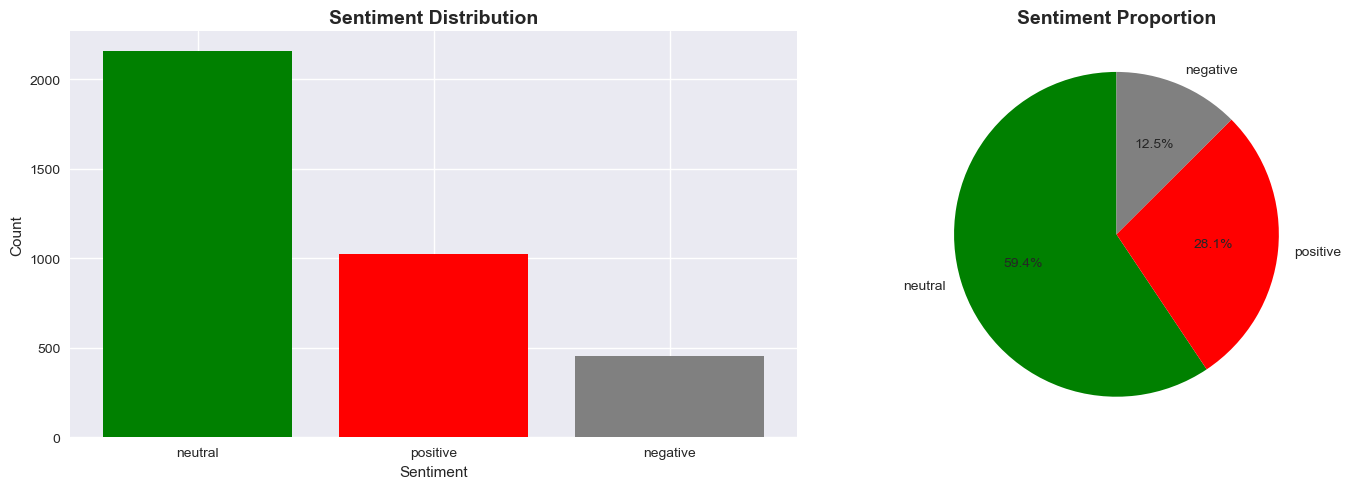

In [4]:
# Sentiment Distribution Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
sentiment_counts = df['Sentiment'].value_counts()
axes[0].bar(sentiment_counts.index, sentiment_counts.values, 
           color=['green', 'red', 'gray'])
axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')

# Pie chart
axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index, 
           autopct='%1.1f%%', startangle=90, colors=['green', 'red', 'gray'])
axes[1].set_title('Sentiment Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

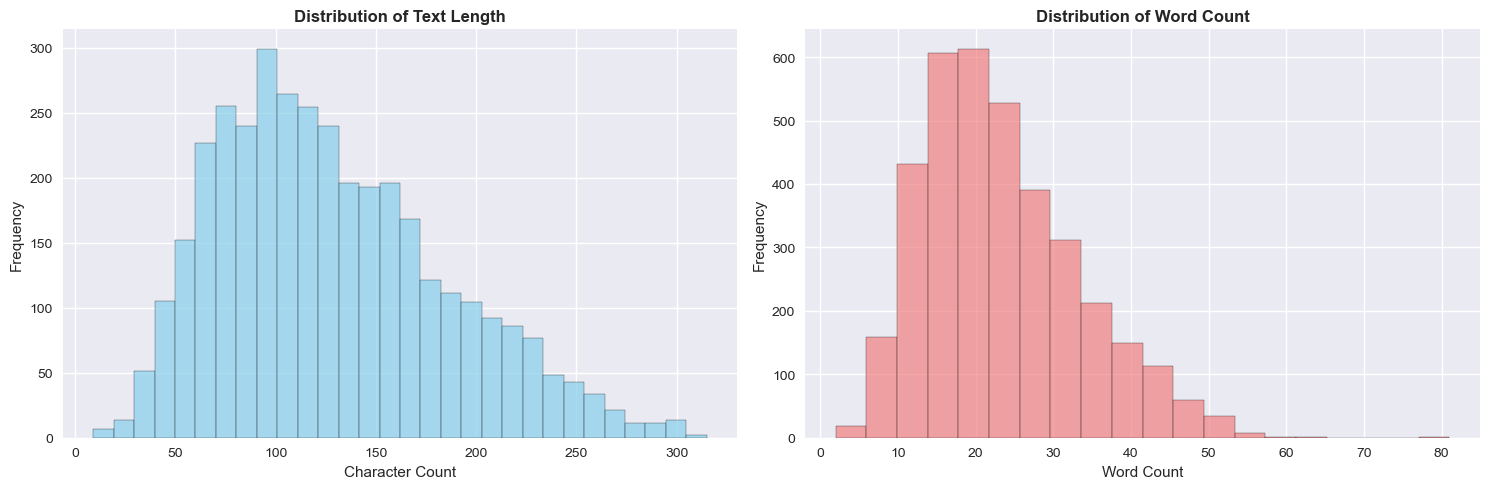

Average text length: 128.0 characters
Average word count: 23.1 words


In [5]:
# Text Length Analysis
df['text_length'] = df['News Headline'].str.len()
df['word_count'] = df['News Headline'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Text length distribution
axes[0].hist(df['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Text Length', fontweight='bold')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')

# Word count distribution
axes[1].hist(df['word_count'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_title('Distribution of Word Count', fontweight='bold')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Average text length: {df['text_length'].mean():.1f} characters")
print(f"Average word count: {df['word_count'].mean():.1f} words")

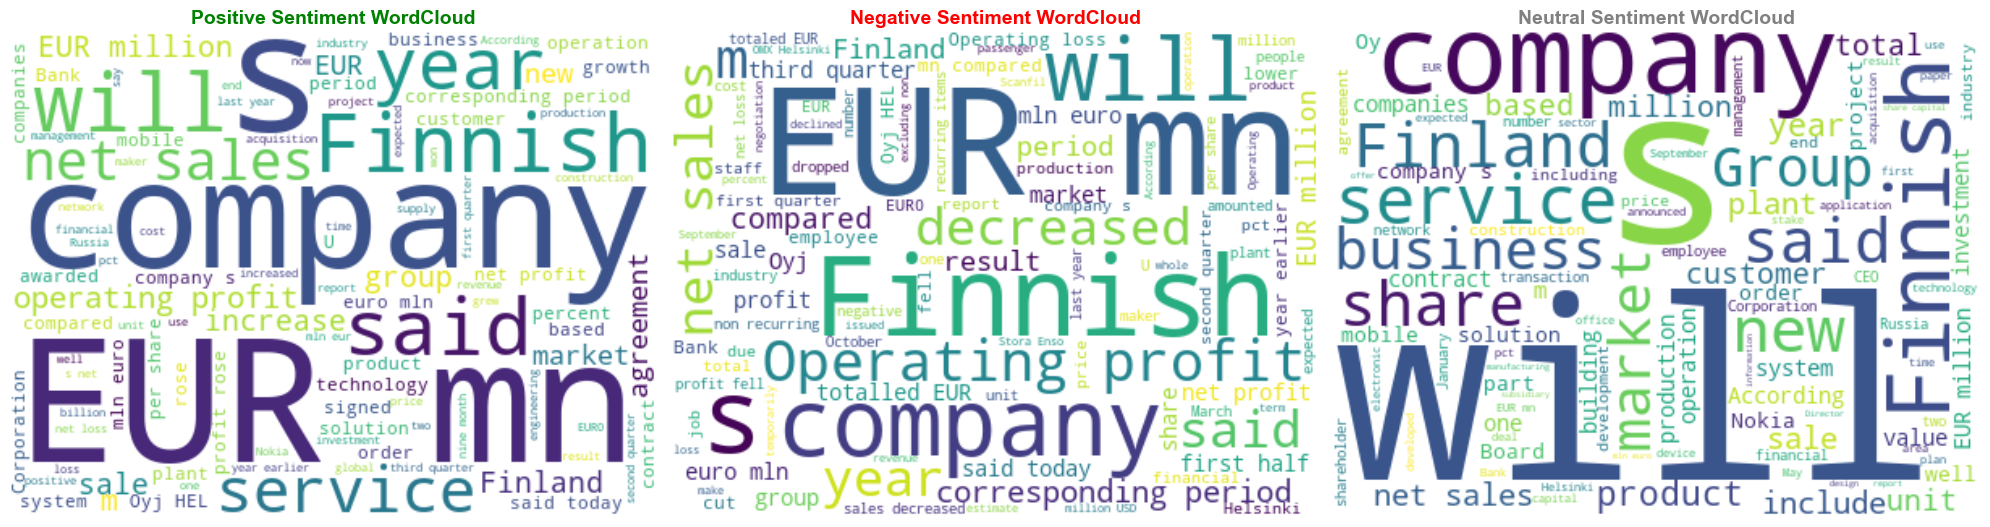

In [6]:
# WordCloud for Each Sentiment
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sentiments = ['positive', 'negative', 'neutral']
colors = ['green', 'red', 'gray']

for i, sentiment in enumerate(sentiments):
    text = ' '.join(df[df['Sentiment'] == sentiment]['News Headline'].astype(str))
    
    wordcloud = WordCloud(width=400, height=300, 
                         background_color='white',
                         colormap='viridis',
                         max_words=100).generate(text)
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'{sentiment.capitalize()} Sentiment WordCloud', 
                     fontsize=14, fontweight='bold', color=colors[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Text Preprocessing
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    """Comprehensive text preprocessing function"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(tokens)

# Apply preprocessing
df['processed_headline'] = df['News Headline'].apply(preprocess_text)
print("Text preprocessing completed!")
print(f"Sample processed text:\n{df['processed_headline'].iloc[0]}")

[nltk_data] Downloading package punkt to /Users/shreyuu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shreyuu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text preprocessing completed!
Sample processed text:
valu order eur mn


In [8]:
# Prepare Data for Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Encode labels
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['Sentiment'])

# Split data
X = df['processed_headline']
y = df['sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Vectorize text
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Test set shape: {X_test_tfidf.shape}")
print(f"Label mapping: {dict(enumerate(label_encoder.classes_))}")

Training set shape: (2908, 5000)
Test set shape: (728, 5000)
Label mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [9]:
# Train Multiple Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, 
                              target_names=label_encoder.classes_))


Training Logistic Regression...
Logistic Regression Accuracy: 0.7418

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.35      0.48        91
     neutral       0.74      0.96      0.83       432
    positive       0.75      0.45      0.57       205

    accuracy                           0.74       728
   macro avg       0.76      0.59      0.63       728
weighted avg       0.75      0.74      0.71       728


Training Random Forest...
Random Forest Accuracy: 0.7500

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.40      0.53        91
     neutral       0.75      0.95      0.84       432
    positive       0.72      0.49      0.58       205

    accuracy                           0.75       728
   macro avg       0.76      0.61      0.65       728
weighted avg       0.75      0.75      0.73       728


Training SVM...
SVM Accuracy: 0.7280

Classification Report:


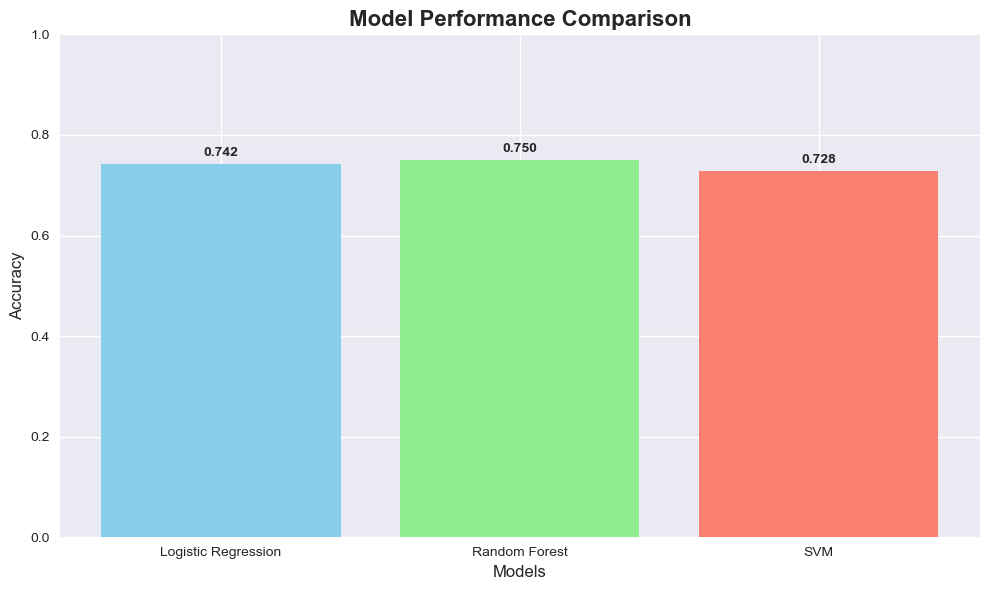


Best performing model: Random Forest with accuracy: 0.7500


In [10]:
# Model Comparison and Results
# Plot model comparison
plt.figure(figsize=(10, 6))
models_list = list(results.keys())
accuracies = list(results.values())

bars = plt.bar(models_list, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print best model
best_model = max(results, key=results.get)
print(f"\nBest performing model: {best_model} with accuracy: {results[best_model]:.4f}")

In [11]:
# Create Prediction Function
def predict_sentiment(headline, model=models['Logistic Regression'], 
                     vectorizer=vectorizer, label_encoder=label_encoder):
    """Function to predict sentiment of a new headline"""
    # Preprocess the headline
    processed = preprocess_text(headline)
    
    # Vectorize
    headline_tfidf = vectorizer.transform([processed])
    
    # Predict
    prediction = model.predict(headline_tfidf)[0]
    probability = model.predict_proba(headline_tfidf)[0]
    
    # Decode prediction
    sentiment = label_encoder.inverse_transform([prediction])[0]
    confidence = max(probability)
    
    return sentiment, confidence

# Test the function
test_headlines = [
    "Bank reports record profits this quarter",
    "Major financial crisis hits the market",
    "Insurance company announces new policy changes"
]

print("Sentiment Predictions:")
print("=" * 50)
for headline in test_headlines:
    sentiment, confidence = predict_sentiment(headline)
    print(f"Headline: {headline}")
    print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence:.3f})")
    print("-" * 50)

Sentiment Predictions:
Headline: Bank reports record profits this quarter
Predicted Sentiment: positive (Confidence: 0.403)
--------------------------------------------------
Headline: Major financial crisis hits the market
Predicted Sentiment: neutral (Confidence: 0.690)
--------------------------------------------------
Headline: Insurance company announces new policy changes
Predicted Sentiment: neutral (Confidence: 0.677)
--------------------------------------------------


In [12]:
# Advanced Machine Learning Models
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import time

# Advanced models dictionary
advanced_models = {
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
}

advanced_results = {}

print("Training Advanced Models...")
print("=" * 50)

for name, model in advanced_models.items():
    start_time = time.time()
    print(f"\nTraining {name}...")
    
    model.fit(X_train_tfidf, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    advanced_results[name] = accuracy
    
    training_time = time.time() - start_time
    print(f"{name} Accuracy: {accuracy:.4f} (Training time: {training_time:.2f}s)")
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5)
    print(f"Cross-validation Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Training Advanced Models...

Training XGBoost...
XGBoost Accuracy: 0.7692 (Training time: 2.23s)
Cross-validation Score: 0.7493 (+/- 0.0308)

Training LightGBM...
LightGBM Accuracy: 0.7143 (Training time: 2.31s)
Cross-validation Score: 0.6967 (+/- 0.0137)

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.7404 (Training time: 3.73s)
Cross-validation Score: 0.7414 (+/- 0.0370)

Training Extra Trees...
Extra Trees Accuracy: 0.7363 (Training time: 2.03s)
Cross-validation Score: 0.7228 (+/- 0.0310)

Training Naive Bayes...
Naive Bayes Accuracy: 0.6827 (Training time: 0.00s)
Cross-validation Score: 0.6895 (+/- 0.0135)

Training Neural Network...
Neural Network Accuracy: 0.7308 (Training time: 8.72s)
Cross-validation Score: 0.6988 (+/- 0.0247)


In [13]:
# Hyperparameter Tuning for Best Models
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grids for top models
param_grids = {
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100]
    }
}

tuned_models = {}
tuned_results = {}

print("Hyperparameter Tuning...")
print("=" * 40)

for model_name in ['XGBoost', 'Random Forest', 'LightGBM']:
    print(f"\nTuning {model_name}...")
    
    if model_name == 'XGBoost':
        base_model = XGBClassifier(random_state=42, eval_metric='mlogloss')
    elif model_name == 'Random Forest':
        base_model = RandomForestClassifier(random_state=42)
    else:  # LightGBM
        base_model = LGBMClassifier(random_state=42, verbose=-1)
    
    # Randomized search for faster tuning
    random_search = RandomizedSearchCV(
        base_model, 
        param_grids[model_name], 
        n_iter=20, 
        cv=3, 
        random_state=42, 
        n_jobs=-1,
        scoring='accuracy'
    )
    
    random_search.fit(X_train_tfidf, y_train)
    
    # Best model
    best_model = random_search.best_estimator_
    tuned_models[model_name] = best_model
    
    # Evaluate
    y_pred_tuned = best_model.predict(X_test_tfidf)
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    tuned_results[model_name] = accuracy_tuned
    
    print(f"Best {model_name} Accuracy: {accuracy_tuned:.4f}")
    print(f"Best Parameters: {random_search.best_params_}")

Hyperparameter Tuning...

Tuning XGBoost...
Best XGBoost Accuracy: 0.7610
Best Parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}

Tuning Random Forest...
Best Random Forest Accuracy: 0.7514
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

Tuning LightGBM...
Best LightGBM Accuracy: 0.7376
Best Parameters: {'num_leaves': 50, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


In [14]:
# Ensemble Methods
# Create ensemble models
ensemble_models = {}

# Voting Classifier (Hard Voting)
voting_hard = VotingClassifier(
    estimators=[
        ('lr', models['Logistic Regression']),
        ('rf', models['Random Forest']),
        ('xgb', advanced_models['XGBoost']),
        ('lgb', advanced_models['LightGBM'])
    ],
    voting='hard'
)

# Voting Classifier (Soft Voting)
voting_soft = VotingClassifier(
    estimators=[
        ('lr', models['Logistic Regression']),
        ('rf', models['Random Forest']),
        ('xgb', advanced_models['XGBoost']),
        ('lgb', advanced_models['LightGBM'])
    ],
    voting='soft'
)

ensemble_models['Voting Hard'] = voting_hard
ensemble_models['Voting Soft'] = voting_soft

# Stacking Classifier
from sklearn.ensemble import StackingClassifier

stacking_classifier = StackingClassifier(
    estimators=[
        ('lr', models['Logistic Regression']),
        ('rf', models['Random Forest']),
        ('xgb', advanced_models['XGBoost']),
        ('lgb', advanced_models['LightGBM']),
        ('nb', advanced_models['Naive Bayes'])
    ],
    final_estimator=LogisticRegression(random_state=42),
    cv=5
)

ensemble_models['Stacking'] = stacking_classifier

# Train ensemble models
ensemble_results = {}

print("Training Ensemble Models...")
print("=" * 40)

for name, model in ensemble_models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    ensemble_results[name] = accuracy
    
    training_time = time.time() - start_time
    print(f"{name} Accuracy: {accuracy:.4f} (Training time: {training_time:.2f}s)")

Training Ensemble Models...

Training Voting Hard...
Voting Hard Accuracy: 0.7596 (Training time: 3.95s)

Training Voting Soft...
Voting Soft Accuracy: 0.7665 (Training time: 4.07s)

Training Stacking...
Stacking Accuracy: 0.7651 (Training time: 23.93s)


In [15]:
# Deep Learning with Neural Networks
from sklearn.neural_network import MLPClassifier

# Different neural network architectures
nn_models = {
    'NN_Small': MLPClassifier(
        hidden_layer_sizes=(50,), 
        activation='relu', 
        solver='adam', 
        max_iter=1000, 
        random_state=42
    ),
    'NN_Medium': MLPClassifier(
        hidden_layer_sizes=(100, 50), 
        activation='relu', 
        solver='adam', 
        max_iter=1000, 
        random_state=42
    ),
    'NN_Large': MLPClassifier(
        hidden_layer_sizes=(200, 100, 50), 
        activation='relu', 
        solver='adam', 
        max_iter=1000, 
        random_state=42
    ),
    'NN_Dropout': MLPClassifier(
        hidden_layer_sizes=(100, 50), 
        activation='relu', 
        solver='adam', 
        max_iter=1000, 
        alpha=0.01,  # L2 regularization
        random_state=42
    )
}

nn_results = {}

print("Training Neural Network Models...")
print("=" * 45)

for name, model in nn_models.items():
    print(f"\nTraining {name}...")
    
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    nn_results[name] = accuracy
    
    print(f"{name} Accuracy: {accuracy:.4f}")

Training Neural Network Models...

Training NN_Small...
NN_Small Accuracy: 0.7308

Training NN_Medium...
NN_Medium Accuracy: 0.7308

Training NN_Large...
NN_Large Accuracy: 0.7266

Training NN_Dropout...
NN_Dropout Accuracy: 0.7459


In [16]:
%pip install torch --quiet

# BERT-based Models (Transformer Models)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Custom dataset class for BERT
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

# Initialize BERT tokenizer and model
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label_encoder.classes_)
).to(device)

# Create datasets
train_dataset = SentimentDataset(X_train, y_train, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, tokenizer)

print(f"BERT model loaded: {model_name}")
print(f"Number of labels: {len(label_encoder.classes_)}")

Note: you may need to restart the kernel to use updated packages.
Using device: cpu


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded: distilbert-base-uncased
Number of labels: 3


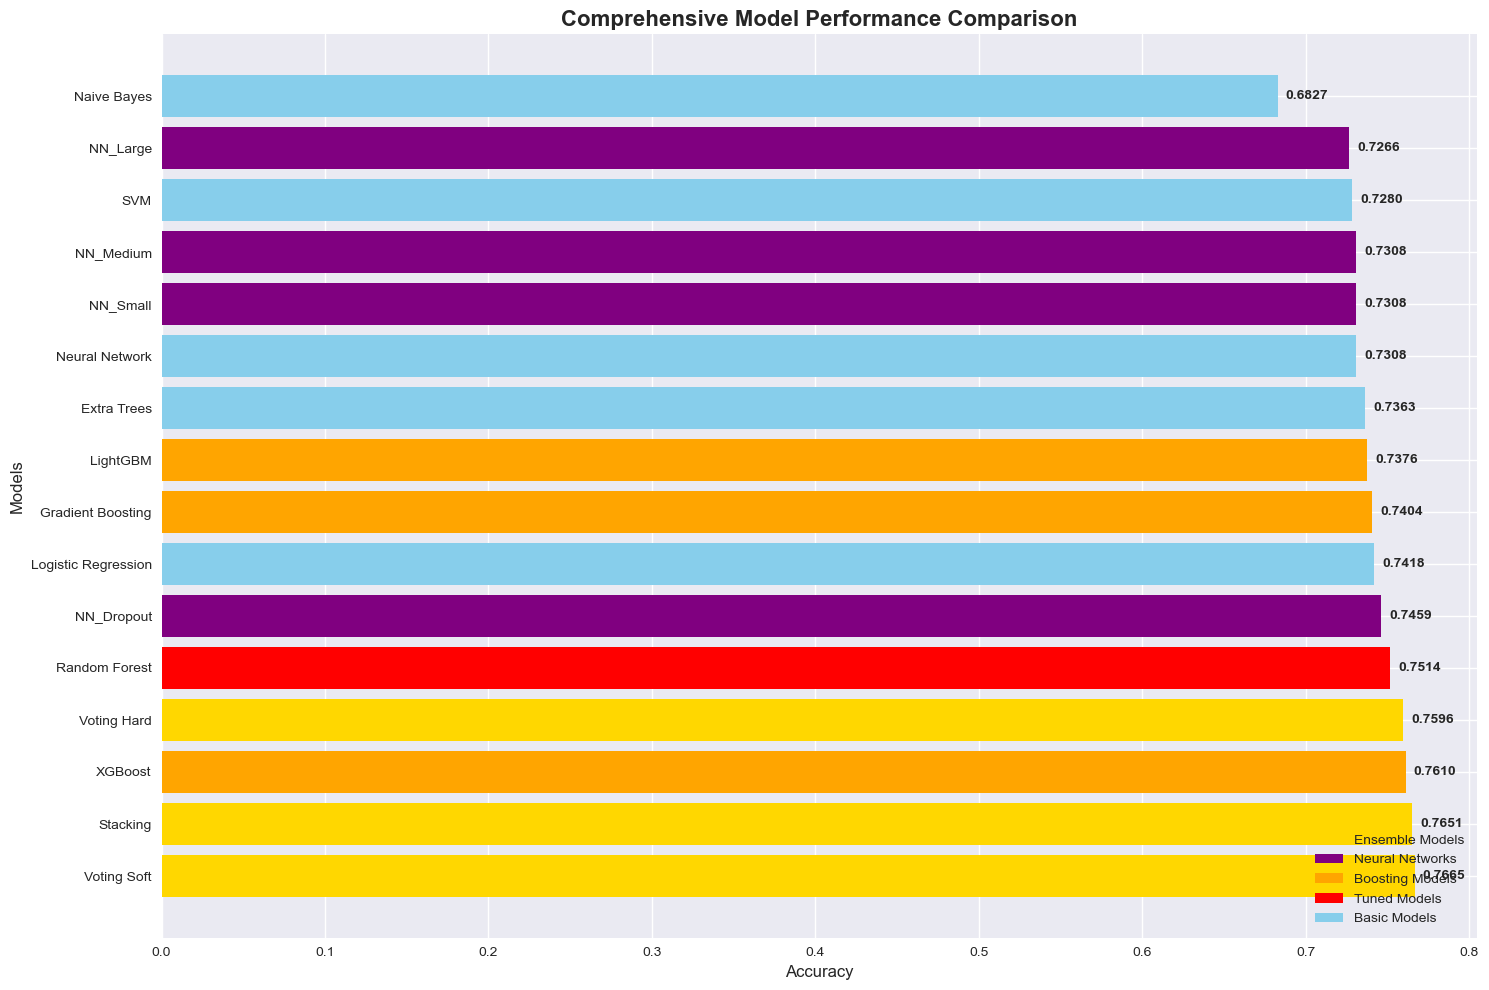


Top 5 Performing Models:
1. Voting Soft: 0.7665
2. Stacking: 0.7651
3. XGBoost: 0.7610
4. Voting Hard: 0.7596
5. Random Forest: 0.7514

Best Model: Voting Soft
Best Accuracy: 0.7665


In [17]:
# Comprehensive Results Comparison
# Combine all results
all_results = {}
all_results.update(results)  # Original models
all_results.update(advanced_results)  # Advanced models
all_results.update(tuned_results)  # Tuned models
all_results.update(ensemble_results)  # Ensemble models
all_results.update(nn_results)  # Neural network models

# Sort results by accuracy
sorted_results = sorted(all_results.items(), key=lambda x: x[1], reverse=True)

# Create comprehensive comparison plot
plt.figure(figsize=(15, 10))
models_list = [item[0] for item in sorted_results]
accuracies = [item[1] for item in sorted_results]

# Create color map for different model types
colors = []
for model_name in models_list:
    if 'Voting' in model_name or 'Stacking' in model_name:
        colors.append('gold')  # Ensemble models
    elif 'NN_' in model_name:
        colors.append('purple')  # Neural networks
    elif model_name in ['XGBoost', 'LightGBM', 'Gradient Boosting']:
        colors.append('orange')  # Boosting models
    elif 'tuned' in model_name.lower() or model_name in tuned_results:
        colors.append('red')  # Tuned models
    else:
        colors.append('skyblue')  # Basic models

bars = plt.barh(models_list, accuracies, color=colors)
plt.title('Comprehensive Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Models', fontsize=12)

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{acc:.4f}', ha='left', va='center', fontweight='bold')

# Add legend
legend_elements = [
    plt.Rectangle((0,0),1,1, facecolor='gold', label='Ensemble Models'),
    plt.Rectangle((0,0),1,1, facecolor='purple', label='Neural Networks'),
    plt.Rectangle((0,0),1,1, facecolor='orange', label='Boosting Models'),
    plt.Rectangle((0,0),1,1, facecolor='red', label='Tuned Models'),
    plt.Rectangle((0,0),1,1, facecolor='skyblue', label='Basic Models')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Print top 5 models
print("\nTop 5 Performing Models:")
print("=" * 40)
for i, (model_name, accuracy) in enumerate(sorted_results[:5], 1):
    print(f"{i}. {model_name}: {accuracy:.4f}")

# Best model details
best_model_name, best_accuracy = sorted_results[0]
print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")

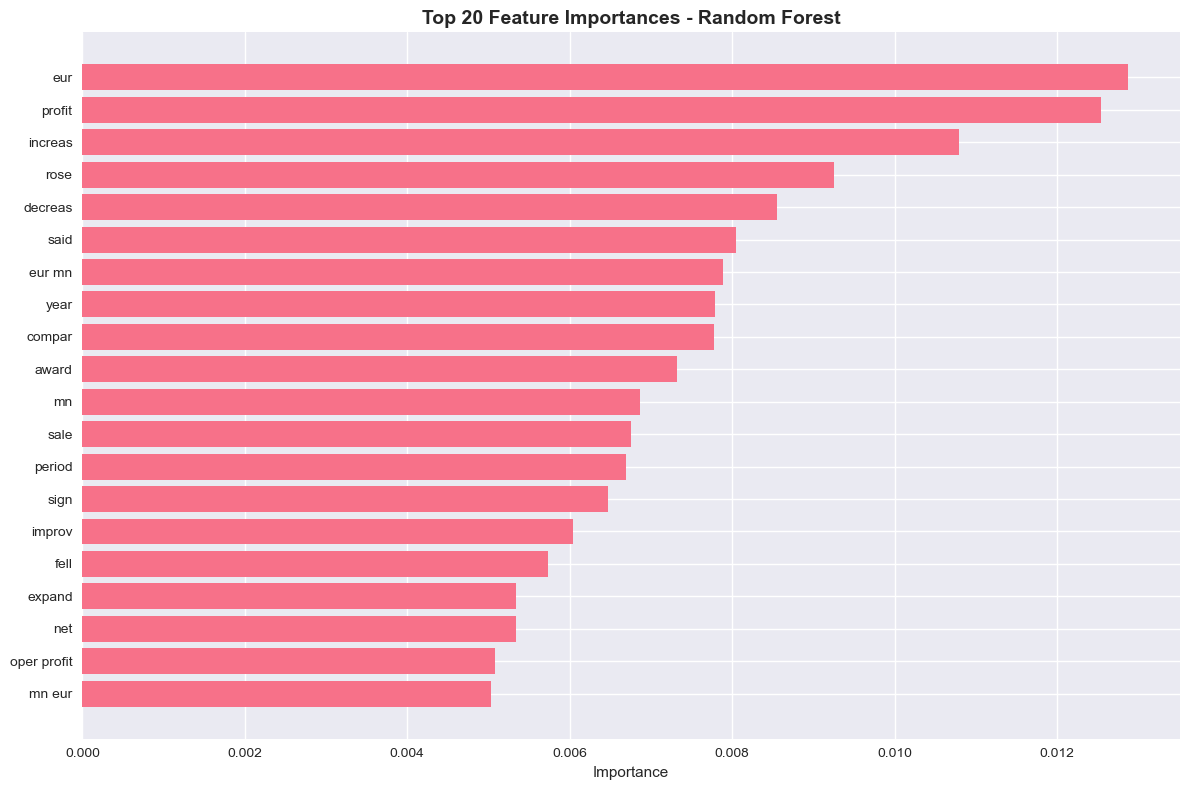


Top 10 Most Important Features for Random Forest:
1. eur: 0.0129
2. profit: 0.0125
3. increas: 0.0108
4. rose: 0.0093
5. decreas: 0.0085
6. said: 0.0080
7. eur mn: 0.0079
8. year: 0.0078
9. compar: 0.0078
10. award: 0.0073


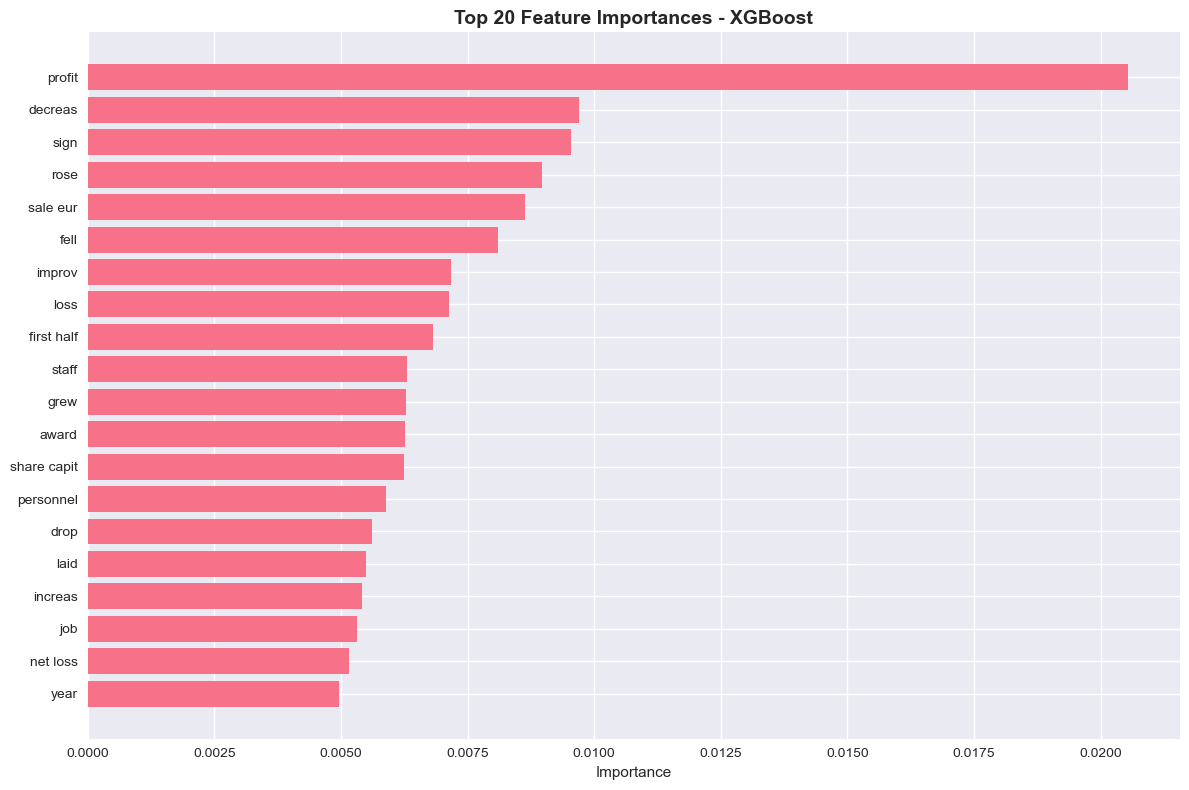


Top 10 Most Important Features for XGBoost:
1. profit: 0.0205
2. decreas: 0.0097
3. sign: 0.0095
4. rose: 0.0090
5. sale eur: 0.0086
6. fell: 0.0081
7. improv: 0.0072
8. loss: 0.0071
9. first half: 0.0068
10. staff: 0.0063


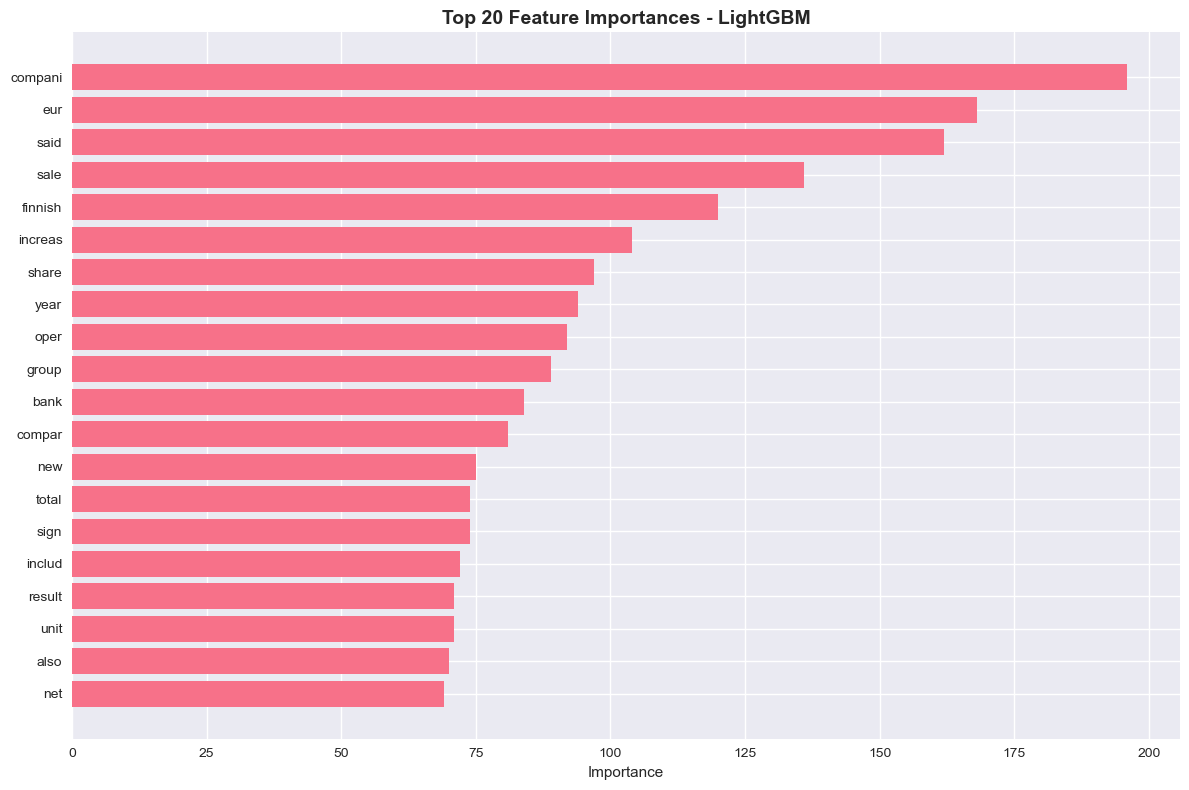


Top 10 Most Important Features for LightGBM:
1. compani: 196.0000
2. eur: 168.0000
3. said: 162.0000
4. sale: 136.0000
5. finnish: 120.0000
6. increas: 104.0000
7. share: 97.0000
8. year: 94.0000
9. oper: 92.0000
10. group: 89.0000


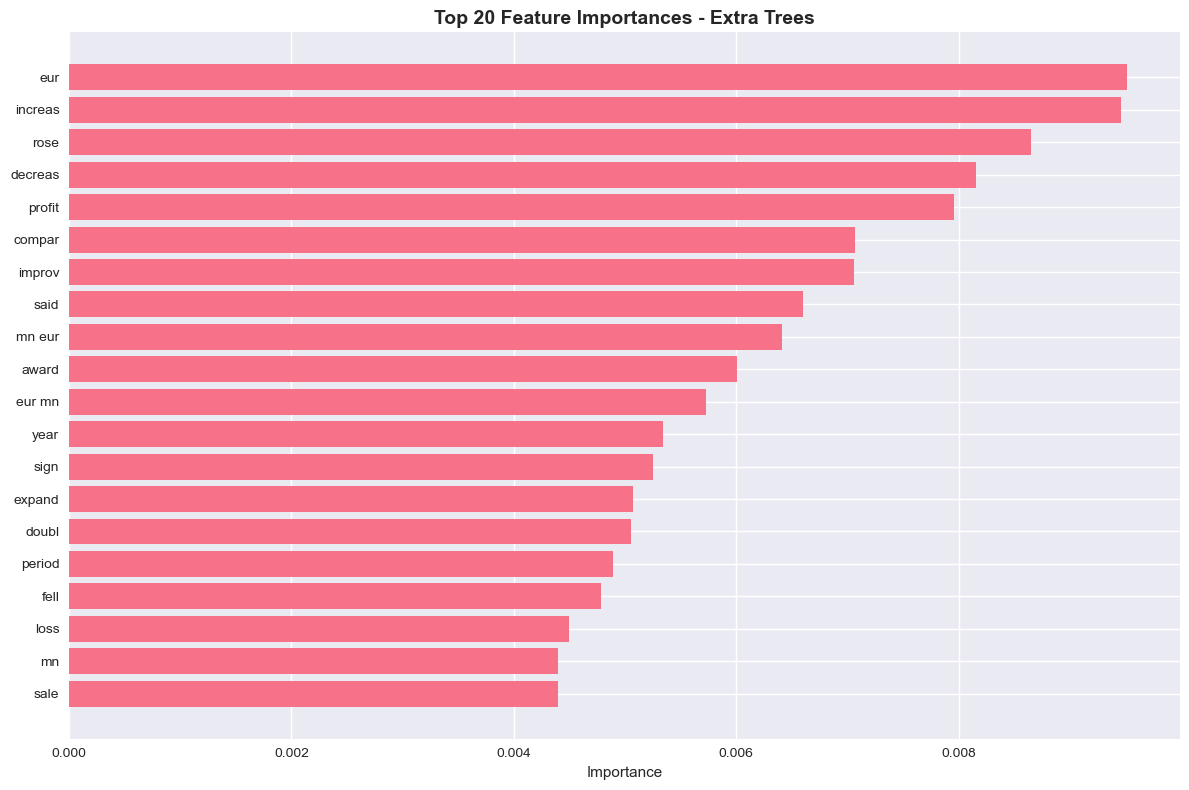


Top 10 Most Important Features for Extra Trees:
1. eur: 0.0095
2. increas: 0.0095
3. rose: 0.0087
4. decreas: 0.0082
5. profit: 0.0080
6. compar: 0.0071
7. improv: 0.0071
8. said: 0.0066
9. mn eur: 0.0064
10. award: 0.0060


In [18]:
# Feature Importance Analysis
from sklearn.inspection import permutation_importance

# Get feature importance for tree-based models
def plot_feature_importance(model, model_name, feature_names, top_n=20):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]
        
        plt.figure(figsize=(12, 8))
        plt.title(f'Top {top_n} Feature Importances - {model_name}', fontsize=14, fontweight='bold')
        plt.barh(range(top_n), importances[indices])
        plt.yticks(range(top_n), [feature_names[i] for i in indices])
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop 10 Most Important Features for {model_name}:")
        for i in range(min(10, len(indices))):
            print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Get feature names from vectorizer
feature_names = vectorizer.get_feature_names_out()

# Plot feature importance for tree-based models
tree_models = ['Random Forest', 'XGBoost', 'LightGBM', 'Extra Trees']
for model_name in tree_models:
    if model_name in advanced_models:
        plot_feature_importance(advanced_models[model_name], model_name, feature_names)
    elif model_name in tuned_models:
        plot_feature_importance(tuned_models[model_name], model_name, feature_names)

In [23]:
# Enhanced Prediction Function with Confidence Intervals
def enhanced_predict_sentiment(headline, models_dict=all_results, top_n=5):
    """Enhanced prediction function using multiple top models"""
    processed = preprocess_text(headline)
    headline_tfidf = vectorizer.transform([processed])
    
    predictions = {}
    
    # Get top N models
    top_models = sorted(all_results.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    for model_name, _ in top_models:
        try:
            if model_name in models:
                model = models[model_name]
            elif model_name in advanced_models:
                model = advanced_models[model_name]
            elif model_name in tuned_models:
                model = tuned_models[model_name]
            elif model_name in ensemble_models:
                model = ensemble_models[model_name]
            elif model_name in nn_models:
                model = nn_models[model_name]
            else:
                continue
                
            pred = model.predict(headline_tfidf)[0]
            if hasattr(model, 'predict_proba'):
                prob = model.predict_proba(headline_tfidf)[0]
                confidence = max(prob)
            else:
                confidence = 0.0
                
            sentiment = label_encoder.inverse_transform([pred])[0]
            predictions[model_name] = (sentiment, confidence)
            
        except Exception as e:
            print(f"Error with {model_name}: {e}")
            continue
    
    # Aggregate predictions (majority vote)
    sentiment_votes = {}
    for model_name, (sentiment, confidence) in predictions.items():
        if sentiment not in sentiment_votes:
            sentiment_votes[sentiment] = []
        sentiment_votes[sentiment].append(confidence)
    
    # Calculate weighted average
    final_predictions = {}
    for sentiment, confidences in sentiment_votes.items():
        avg_confidence = np.mean(confidences)
        vote_count = len(confidences)
        final_predictions[sentiment] = (avg_confidence, vote_count)
    
    # Get final prediction
    final_sentiment = max(final_predictions.keys(), 
                         key=lambda x: final_predictions[x][1])  # By vote count
    
    return final_sentiment, final_predictions, predictions

# Test enhanced prediction
test_headlines_advanced = [
    "He died",
    "Bank reports record quarterly profits exceeding expectations",
    "Financial markets crash amid global economic uncertainty",
    "Insurance company introduces innovative digital services",
    "Central bank raises interest rates to combat inflation",
    "Cryptocurrency exchange faces regulatory challenges",
]

print("Enhanced Sentiment Predictions:")
print("=" * 60)
for headline in test_headlines_advanced:
    final_sentiment, aggregated, individual = enhanced_predict_sentiment(headline)
    
    print(f"\nHeadline: {headline}")
    print(f"Final Prediction: {final_sentiment}")
    print(f"Aggregated Results: {aggregated}")
    print("-" * 60)

Enhanced Sentiment Predictions:

Headline: He died
Final Prediction: neutral
Aggregated Results: {'neutral': (0.7046707091414657, 5)}
------------------------------------------------------------

Headline: Bank reports record quarterly profits exceeding expectations
Final Prediction: neutral
Aggregated Results: {'neutral': (0.380692296101305, 4), 'positive': (0.5879122026447315, 1)}
------------------------------------------------------------

Headline: Financial markets crash amid global economic uncertainty
Final Prediction: neutral
Aggregated Results: {'neutral': (0.6996164599729562, 5)}
------------------------------------------------------------

Headline: Insurance company introduces innovative digital services
Final Prediction: neutral
Aggregated Results: {'neutral': (0.41566077500028237, 3), 'positive': (0.516566090830922, 2)}
------------------------------------------------------------

Headline: Central bank raises interest rates to combat inflation
Final Prediction: neutral
